# Identify different cell types in melanoma based on the expression of metabolic genes using machine learning

The code in this notebook allows to explore if different cell types in melanoma can be identified based on their gene expression profiles. In particular, first RNA-seq data [1] saved in a csv file is loaded into dataframes. We then perform data pre-processing techniques (KNN data imputation) and try to identify cell types by clustering in low-dimensionality representations of the data (Umap, T-SNE). We then apply a deep learning to learn cell types based on 10% of the data as training data.

[1] Itay Tirosh et al. , Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq.Science352,189-196(2016).DOI:10.1126/science.aad0501

## Load libraries

pandas is for handling data frames
numpy is for basic mathematical operations
sklearn is for dimensionality reduction and data imputation
matplotlib and seaborn is for visualization
torch is for building neural network

In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Definition of plotting functions and of the neural network class

In [16]:
# Function to visualize the clustering results
def visualize_clusters3(data, labels, Tumor_labels,Type_labels, title):
   
    n_colors = len(np.unique(labels))
    version_cmap = create_discrete_colormap(n_colors)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
    sc=plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=version_cmap, s=50, alpha=0.5)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(*sc.legend_elements(), title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)

    n_colors = len(np.unique(Tumor_labels))
    version_cmap = create_discrete_colormap(n_colors)
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    sc = plt.scatter(data[:, 0], data[:, 1], c=Tumor_labels, cmap=version_cmap, s=50, alpha=0.5)

    # Translate Legend Entries
    unique_labels = np.unique(Tumor_labels)
    colors = version_cmap(range(n_colors))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=inverted_tumor_dict[label],
                                  markerfacecolor=color, markersize=10) for label, color in zip(unique_labels, colors)]

    # Display the legend with custom labels
    plt.legend(handles=legend_elements, title='Clusters',ncol=1,fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title("Tumor Labels")
    
    n_colors = len(np.unique(Type_labels))
    version_cmap = create_discrete_colormap(n_colors)
    plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
    sc=plt.scatter(data[:, 0], data[:, 1], c=Type_labels, cmap=version_cmap, s=50, alpha=0.5)
    # Translate Legend Entries
    unique_labels = np.unique(Type_labels)
    colors = version_cmap(range(n_colors))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=inverted_cell_type_dict[label],
                                  markerfacecolor=color, markersize=10) for label, color in zip(unique_labels, colors)]

    # Display the legend with custom labels
    plt.legend(handles=legend_elements, title='Clusters',ncol=1,fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title("Cell Type Labels")

    plt.tight_layout()  # This ensures proper spacing between subplots
    plt.show()

In [131]:
# Function to visualize the clustering results
def visualize_clustersCTs(data, labels,Type_labels, title):
   
    n_colors = len(np.unique(labels))
    version_cmap = create_discrete_colormap(n_colors)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    sc=plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=version_cmap, s=50, alpha=0.5)
    # Translate Legend Entries
    unique_labels = np.unique(Type_labels)
    colors = version_cmap(range(n_colors))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=inverted_cell_type_dict[label],
                                  markerfacecolor=color, markersize=10) for label, color in zip(unique_labels, colors)]

    # Display the legend with custom labels
    plt.legend(handles=legend_elements, title='Clusters',ncol=1,fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(*sc.legend_elements(), title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)

    
    n_colors = len(np.unique(Type_labels))
    version_cmap = create_discrete_colormap(n_colors)
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    sc=plt.scatter(data[:, 0], data[:, 1], c=Type_labels, cmap=version_cmap, s=50, alpha=0.5)
    # Translate Legend Entries
    unique_labels = np.unique(Type_labels)
    colors = version_cmap(range(n_colors))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=inverted_cell_type_dict[label],
                                  markerfacecolor=color, markersize=10) for label, color in zip(unique_labels, colors)]

    # Display the legend with custom labels
    plt.legend(handles=legend_elements, title='Clusters',ncol=1,fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title("Cell Type Labels")

    plt.tight_layout()  # This ensures proper spacing between subplots
    plt.show()

In [92]:
# Function to visualize the clustering results
def visualize_clustersTEs(data, labels, Tumor_labels, title):
   
    n_colors = len(np.unique(labels))
    version_cmap = create_discrete_colormap(n_colors)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    sc=plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=version_cmap, s=50, alpha=0.5)
    # Translate Legend Entries
    unique_labels = np.unique(Tumor_labels)
    colors = version_cmap(range(n_colors))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=inverted_tumor_dict[label],
                                  markerfacecolor=color, markersize=10) for label, color in zip(unique_labels, colors)]

    # Display the legend with custom labels
    plt.legend(handles=legend_elements, title='Clusters',ncol=1,fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)

    n_colors = len(np.unique(Tumor_labels))
    version_cmap = create_discrete_colormap(n_colors)
    plt.subplot(1, 2, 2)  # 1 row, 3 columns, 2nd subplot
    sc = plt.scatter(data[:, 0], data[:, 1], c=Tumor_labels, cmap=version_cmap, s=50, alpha=0.5)

    # Translate Legend Entries
    unique_labels = np.unique(Tumor_labels)
    colors = version_cmap(range(n_colors))
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=inverted_tumor_dict[label],
                                  markerfacecolor=color, markersize=10) for label, color in zip(unique_labels, colors)]

    # Display the legend with custom labels
    plt.legend(handles=legend_elements, title='Clusters',ncol=1,fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title("Tumor Labels")

    plt.tight_layout()  # This ensures proper spacing between subplots
    plt.show()

In [30]:
def generate_distinct_colors(n_colors):
    # Using seaborn's color_palette() function to get distinct colors
    colors = sns.color_palette('turbo', n_colors)
    return colors

In [4]:
def create_discrete_colormap(n_colors):
    colors = generate_distinct_colors(n_colors)
    cmap = ListedColormap(colors)
    return cmap

In [37]:
# Define the custom neural network
class CustomNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers):
        super(CustomNet, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_dim, hidden_dim)]
        
        # Hidden layers
        for i in range(num_hidden_layers):
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        
        # Assemble the layers into a sequential module
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.net(x)

## Load in data set and set the labels of cell types and the turmor environment

In [5]:
# Load in data from csv file
df = pd.read_csv('melanoma_raw_data.csv', header=None)


# Extract the tumor environment names from the first row
tumor_names = df.iloc[0].tolist()
unique_tumors = set(tumor_names)
unique_tumors.remove('Tumor')

# Create a dictionary to map tumor names to integers in ascending order
tumor_dict = {name: i + 1 for i, name in enumerate(unique_tumors)}

# Replace the tumor names with integers in the DataFrame
df.replace(tumor_dict, inplace=True)


# Extract the cell type labels from the second row
cell_type_labels = df.iloc[1].tolist()
unique_cell_types = set(cell_type_labels)
unique_cell_types.remove('CellType')

# Create a dictionary to map cell type labels to integers in ascending order
cell_type_dict = {label: i + 1 for i, label in enumerate(unique_cell_types)}

# Replace the cell type labels with integers in the DataFrame
df.replace(cell_type_dict, inplace=True)


# Transpose the DataFrame to have cells as rows and genes as columns
df = df.T

# Drop the first and second rows and set the first row and column as the column names and index (gene names)
df.columns = df.iloc[0]
df = df[1:]  # Drop the first and second rows


# Drop any rows with missing gene names (if any)
df = df.dropna(subset=[df.columns[0]])

# Show the resulting DataFrame
print(df)

/home/fmeigel/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,2

0    Tumor CellType C9orf152   RPS11   ELMO2 CREB3L1 PNMA1     MMP2 TMEM216  \
1       10        5        0  9.2172       0       0     0        0       0   
2       18        3        0  8.3745       0       0     0        0       0   
3        7        4        0   9.313  2.1263       0     0  0.73812       0   
4       13        4        0  7.8876       0       0     0        0       0   
5       12        4        0  8.3291       0       0     0        0  3.7949   
...    ...      ...      ...     ...     ...     ...   ...      ...     ...   
4050     6        3        0  6.2734       0       0     0        0       0   
4051     6        3        0  5.4889       0       0     0        0       0   
4052     6        3        0  4.9262  5.5296       0     0        0       0   
4053     6        3        0  7.0958       0       0     0        0       0   
4054     6        3        0   3.997       0       0     0        0       0   

0    TRAF3IP2-AS1  ...    GPLD1 SNORD115-39   RAB8A

In [6]:
#Check the Tumor dictionary
print(tumor_dict)
inverted_tumor_dict = {value: key for key, value in tumor_dict.items()}
print(inverted_tumor_dict)

{'MEL15': 1, 'MEL19': 2, 'MEL16': 3, 'MEL3': 4, 'MEL17': 5, 'MEL10': 6, 'MEL7': 7, 'MEL6': 8, 'MEL18': 9, 'MEL8': 10, 'MEL12': 11, 'MEL13': 12, 'MEL14': 13, 'MEL4': 14, 'MEL11': 15, 'MEL9': 16, 'MEL5': 17, 'MEL2': 18, 'MEL1': 19}
{1: 'MEL15', 2: 'MEL19', 3: 'MEL16', 4: 'MEL3', 5: 'MEL17', 6: 'MEL10', 7: 'MEL7', 8: 'MEL6', 9: 'MEL18', 10: 'MEL8', 11: 'MEL12', 12: 'MEL13', 13: 'MEL14', 14: 'MEL4', 15: 'MEL11', 16: 'MEL9', 17: 'MEL5', 18: 'MEL2', 19: 'MEL1'}


In [7]:
#Check the Cell Type dictionary
print(cell_type_dict)
inverted_cell_type_dict = {value: key for key, value in cell_type_dict.items()}
print(inverted_cell_type_dict)

{'CAF': 1, 'Endothelial': 2, 'T cell': 3, 'malignant': 4, 'B cell': 5, 'NK': 6, 'Macrophage': 7}
{1: 'CAF', 2: 'Endothelial', 3: 'T cell', 4: 'malignant', 5: 'B cell', 6: 'NK', 7: 'Macrophage'}


In [8]:
#Get rid of the labels
df_cut=df.iloc[:, 2:].copy()
#Replace wrongly identified strings
df_cut.replace('0', 0, inplace=True)
print(df_cut)

0    C9orf152   RPS11   ELMO2 CREB3L1 PNMA1     MMP2 TMEM216 TRAF3IP2-AS1  \
1           0  9.2172       0       0     0        0       0       2.8514   
2           0  8.3745       0       0     0        0       0       2.0983   
3           0   9.313  2.1263       0     0  0.73812       0       0.6173   
4           0  7.8876       0       0     0        0       0      0.96495   
5           0  8.3291       0       0     0        0  3.7949       1.4735   
...       ...     ...     ...     ...   ...      ...     ...          ...   
4050        0  6.2734       0       0     0        0       0       1.3409   
4051        0  5.4889       0       0     0        0       0       2.4052   
4052        0  4.9262  5.5296       0     0        0       0       1.6988   
4053        0  7.0958       0       0     0        0       0       1.5589   
4054        0   3.997       0       0     0        0       0      0.47125   

0    LRRC37A5P   LOC653712  ...    GPLD1 SNORD115-39   RAB8A RXFP2   PCIF1 

## Perform a naïve dimensionality reduction on the full data set

In [32]:
# Perform dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_cut)

# Perform dimensionality reduction using UMAP
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(df_cut)

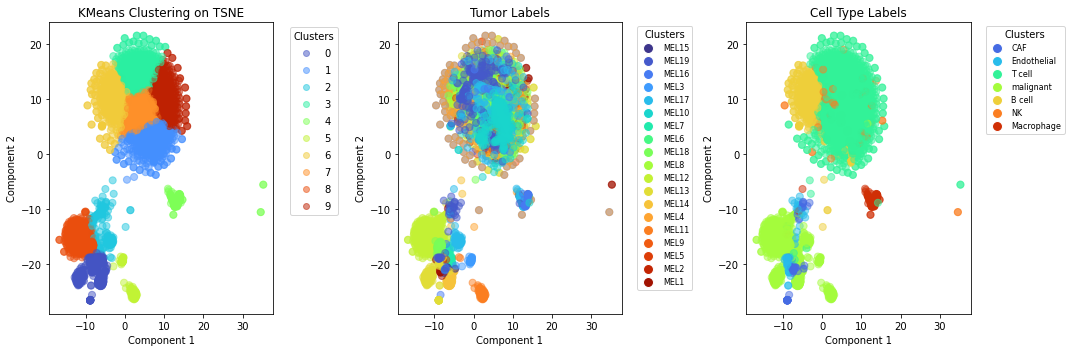

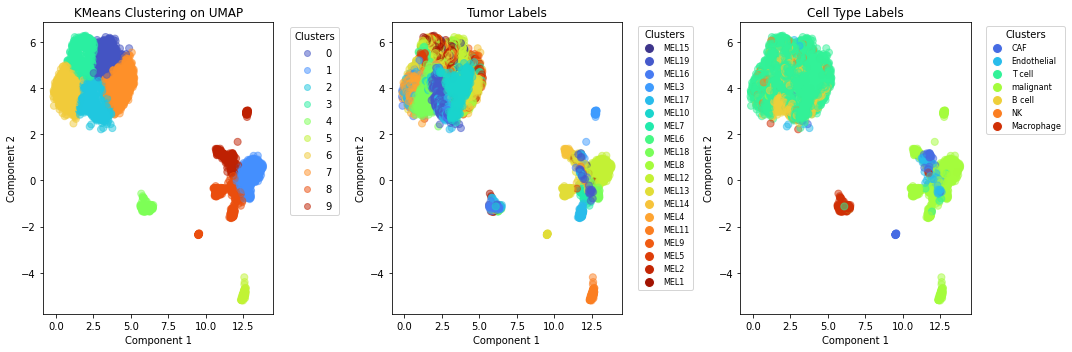

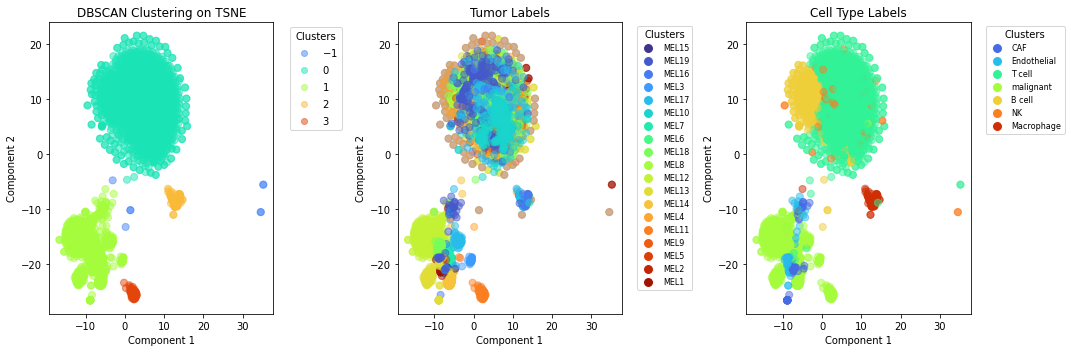

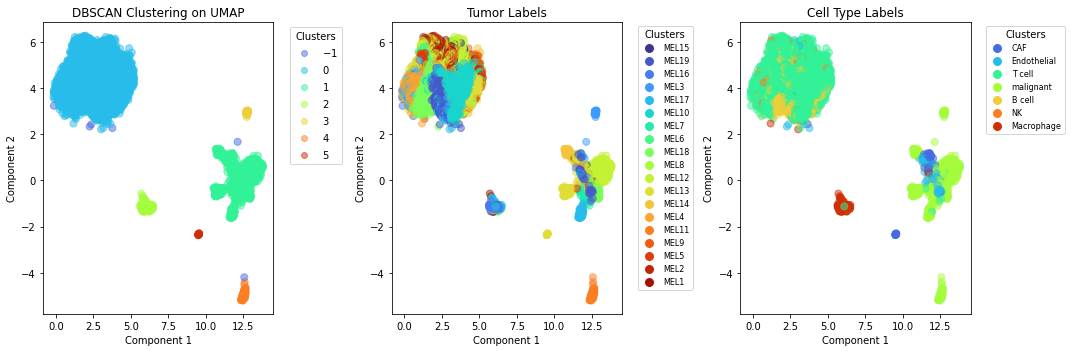

In [33]:
# Perform KMeans clustering on TSNE results
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_labels = kmeans.fit_predict(tsne_result)
visualize_clusters3(tsne_result, kmeans_tsne_labels, df.iloc[:, 0], df.iloc[:, 1], "KMeans Clustering on TSNE")

# Perform KMeans clustering on UMAP results
kmeans_umap_labels = kmeans.fit_predict(umap_result)
visualize_clusters3(umap_result, kmeans_umap_labels, df.iloc[:, 0], df.iloc[:, 1], "KMeans Clustering on UMAP")

# Perform DBSCAN clustering on TSNE results
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_tsne_labels = dbscan.fit_predict(tsne_result)
visualize_clusters3(tsne_result, dbscan_tsne_labels, df.iloc[:, 0], df.iloc[:, 1], "DBSCAN Clustering on TSNE")

# Perform DBSCAN clustering on UMAP results
dbscan_umap = DBSCAN(eps=0.3, min_samples=10)
dbscan_umap_labels = dbscan_umap.fit_predict(umap_result)
visualize_clusters3(umap_result, dbscan_umap_labels, df.iloc[:, 0], df.iloc[:, 1], "DBSCAN Clustering on UMAP")


We find that both t-sne and umap succeed in sepating a small subset of tumors while the majority of tumors are intermixed into a larger tumor.
We find that both t-sne and umap succeed in sepating the majority of cell types. Here B cells and T cells are intermixed. CAF and Endothelial cells appaer intermixed. Natural Killer cells appear intermixed.
We find that malignant cells are well separated from non-malignant cells and that malignant cells are seperated into several subclusters, which seperated several tumor-environments. This indicates that tumors are highly heterogeneous.

K-means clustering is not sufficient in identifying either different tumor environment nor different cell types.
DBSCAN manages to identify different clusters, namely macrophages and malignantc cell, but fails to reveal the full structure of the data set.

## Dimensionality reduction on a subset of the data

Inspecting the data set, we find that the data set is sparse as most entries correspond to 0.
We interprete 0 entries as failed measurments. We thus filter down to genes with the lowest number of failed measurements.

In [34]:
# Calculate the number of 0 entries in each column
zero_counts = (df_cut == 0).sum()

# Sort the columns based on the number of 0 entries in ascending order
sorted_columns = zero_counts.sort_values()

# Select the first 1000 columns from the sorted DataFrame
filtered_df = df_cut[sorted_columns.index[:1000]].copy()

In [35]:
# Perform dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(filtered_df)

# Perform dimensionality reduction using UMAP
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(filtered_df)

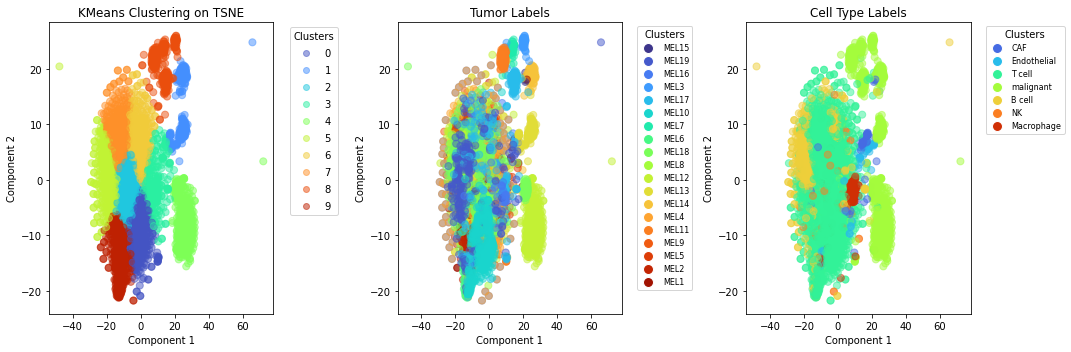

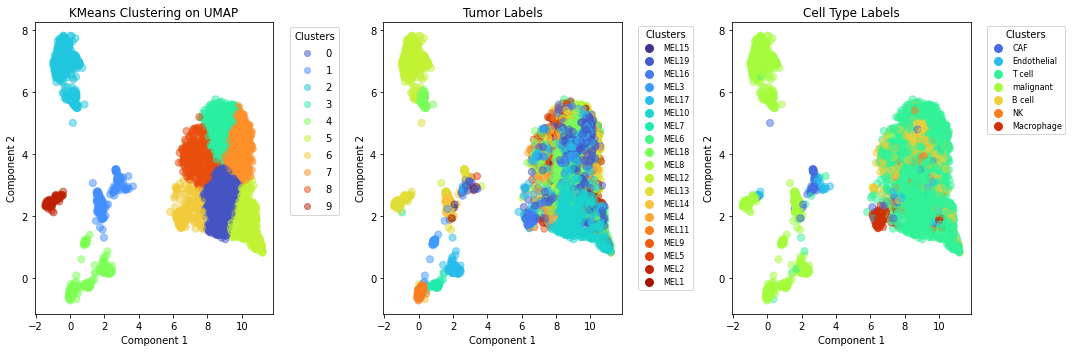

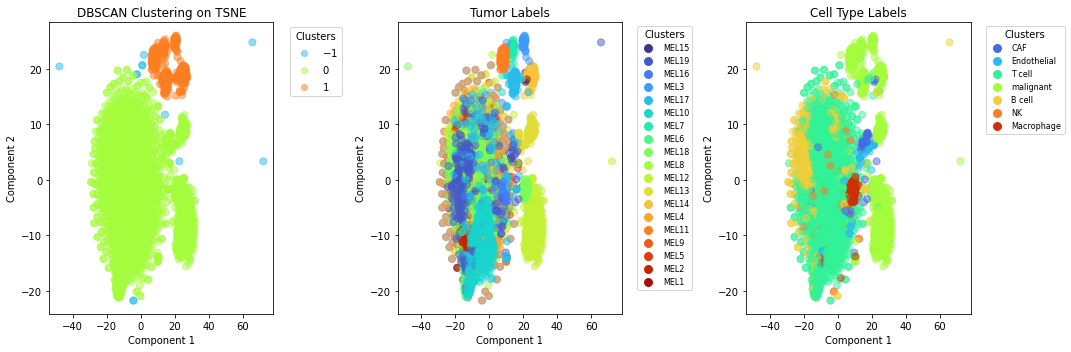

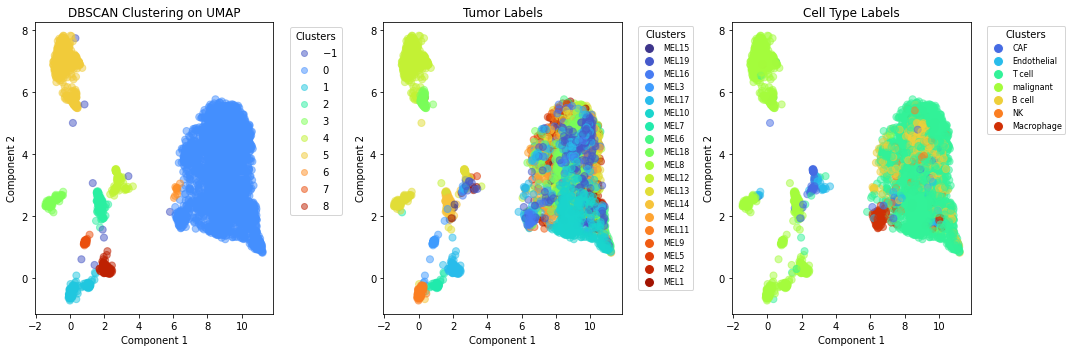

In [36]:
# Perform KMeans clustering on TSNE results
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_labels = kmeans.fit_predict(tsne_result)
visualize_clusters3(tsne_result, kmeans_tsne_labels, df.iloc[:, 0], df.iloc[:, 1], "KMeans Clustering on TSNE")

# Perform KMeans clustering on UMAP results
kmeans_umap_labels = kmeans.fit_predict(umap_result)
visualize_clusters3(umap_result, kmeans_umap_labels, df.iloc[:, 0], df.iloc[:, 1], "KMeans Clustering on UMAP")

# Perform DBSCAN clustering on TSNE results
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_tsne_labels = dbscan.fit_predict(tsne_result)
visualize_clusters3(tsne_result, dbscan_tsne_labels, df.iloc[:, 0], df.iloc[:, 1], "DBSCAN Clustering on TSNE")

# Perform DBSCAN clustering on UMAP results
dbscan_umap = DBSCAN(eps=0.3, min_samples=10)
dbscan_umap_labels = dbscan_umap.fit_predict(umap_result)
visualize_clusters3(umap_result, dbscan_umap_labels, df.iloc[:, 0], df.iloc[:, 1], "DBSCAN Clustering on UMAP")

With a subset of the genes, we can still reproduce the clusering as performed for the full gene set.
We find that both t-sne and umap succeed in sepating a small subset of tumors while the majority of tumors are intermixed into a larger tumor.
We find that both t-sne and umap succeed in sepating the majority of cell types. Here B cells and T cells are intermixed. CAF and Endothelial cells appaer intermixed. Natural Killer cells appear intermixed.
We find that malignant cells are well separated from non-malignant cells and that malignant cells are seperated into several subclusters, which seperated several tumor-environments. This indicates that tumors are highly heterogeneous.

## Additionally account for missing data imputation

Additionally, we perform missing data imputation via k-nearest neighbours. By this, we make sure that the clustering is not due to techincal deviations.

In [269]:
# Select the first 1000 columns from the sorted DataFrame
filtered_df = df_cut[sorted_columns.index[:1000]].copy()

filtered_df.replace(0, np.nan, inplace=True)

# Convert X to a NumPy array since KNNImputer requires a NumPy array as input
X_array = filtered_df.values

In [270]:
k = 10  # Number of neighbors to consider (you can choose any value that suits your data)
imputer = KNNImputer(n_neighbors=k)

# Perform imputation
X_imputed = imputer.fit_transform(X_array)

# Convert X_imputed back to a DataFrame (if desired)
Imputed_df = pd.DataFrame(X_imputed, columns=filtered_df.columns)

In [271]:
# Perform dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(Imputed_df)

# Perform dimensionality reduction using UMAP
umap_result = umap.UMAP(n_components=2, random_state=42).fit_transform(Imputed_df)

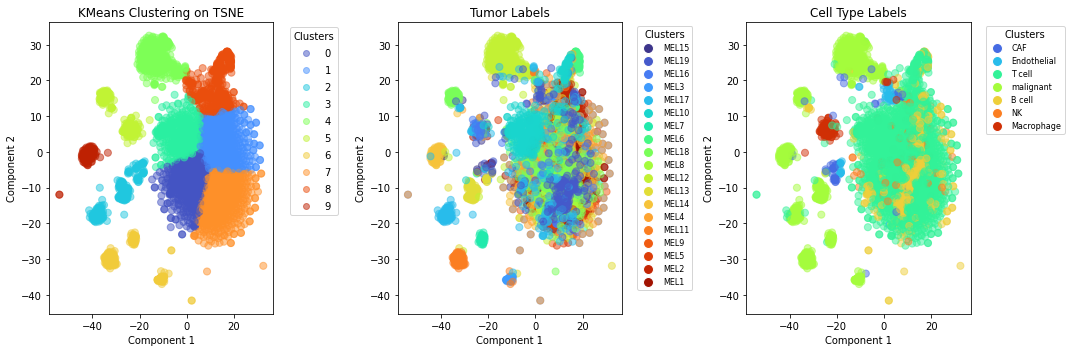

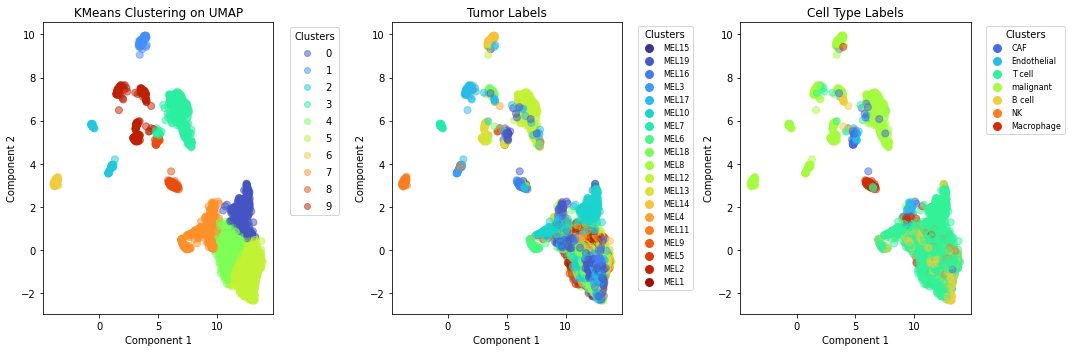

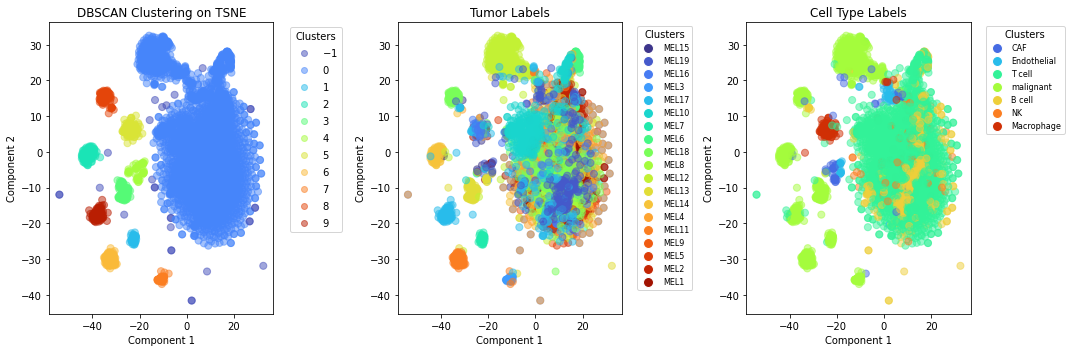

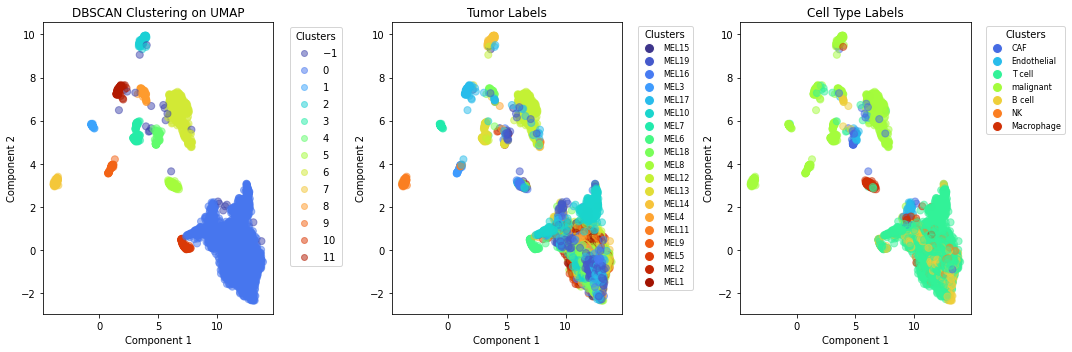

In [272]:
# Perform KMeans clustering on TSNE results
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_tsne_labels = kmeans.fit_predict(tsne_result)
visualize_clusters3(tsne_result, kmeans_tsne_labels, df.iloc[:, 0], df.iloc[:, 1], "KMeans Clustering on TSNE")

# Perform KMeans clustering on UMAP results
kmeans_umap_labels = kmeans.fit_predict(umap_result)
visualize_clusters3(umap_result, kmeans_umap_labels, df.iloc[:, 0], df.iloc[:, 1], "KMeans Clustering on UMAP")

# Perform DBSCAN clustering on TSNE results
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan_tsne_labels = dbscan.fit_predict(tsne_result)
visualize_clusters3(tsne_result, dbscan_tsne_labels, df.iloc[:, 0], df.iloc[:, 1], "DBSCAN Clustering on TSNE")

# Perform DBSCAN clustering on UMAP results
dbscan_umap = DBSCAN(eps=0.3, min_samples=10)
dbscan_umap_labels = dbscan_umap.fit_predict(umap_result)
visualize_clusters3(umap_result, dbscan_umap_labels, df.iloc[:, 0], df.iloc[:, 1], "DBSCAN Clustering on UMAP")

Results are qualitively similar to the prodecure before, but clusters appear more distinct. DBSCAN succeeds in indentifying more clusters, yet the full complexity of the data set cannot be recovered.

## Identify cell types and tumor environments based with machine learning

Comparing classification based dimensionality reduction and machine learning, dimensionality reduction is not by construction primed on identifying all different expected clusters in the data set. Here machine learning in general is expected to perform better. In contrast, dimensionality reduction offers the posinility for unsupervised cluster identification, which can be insghtful to understand if expected clusters are meaningful.

In the analysis above, we idenfitied that a most cell types and a subset of tumore environements are clustered  spatially close in the dimensionality reduction. This motives that identification by machine learning can be successfull. Here we train the deep neural networks on a subset of data and evalutate the predictions.

Note that due to the size of the available data-points, the number of genes to be considered needs to be restricted strongly.

In [276]:
# Calculate the number of 0 entries in each column
zero_counts = (df_cut == 0).sum()

# Sort the columns based on the number of 0 entries in ascending order
sorted_columns = zero_counts.sort_values()

# Select the first 50 columns from the sorted DataFrame
filtered_df = df_cut[sorted_columns.index[:150]].copy()
filtered_df.replace(0, np.nan, inplace=True)

# Convert X to a NumPy array since KNNImputer requires a NumPy array as input
X_array = filtered_df.values

k = 10  # Number of neighbors to consider (you can choose any value that suits your data)
imputer = KNNImputer(n_neighbors=k)

# Perform imputation
X_imputed = imputer.fit_transform(X_array)

# Convert X_imputed back to a DataFrame (if desired)
Imputed_df = pd.DataFrame(X_imputed, columns=filtered_df.columns)

In [277]:
# Split data into training and test sets
y =  df.iloc[:, 1].values

# Train on 10% of the data to demonstrate predictive power
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.9, random_state=42)

# Check the size of the training and testing data set
print([np.size(y_train),np.size(y_test)])

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_series = pd.Series(y_train)
y_train_tensor = torch.tensor(y_train_series, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_series = pd.Series(y_test)
y_test_tensor = torch.tensor(y_test_series, dtype=torch.long)
# Combine X_test_tensor and y_test_tensor to create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader for the test data
test_loader = DataLoader(test_dataset, batch_size=32)

[405, 3649]


In [278]:
# Define Neural network Parameters
input_dim = 150
hidden_dim = 50
output_dim = 9
num_hidden_layers = 3  # You can change this value to control the number of hidden layers

# Create an instance of the neural network
model = CustomNet(input_dim, hidden_dim, output_dim, num_hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [279]:
# Assuming you have already created X_train_tensor and y_train_tensor from X_train and y_train respectively.

# Training loop
num_epochs = 100
batch_size = 10

# Training loop
num_epochs = 500
batch_size = 10

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        # Extract a batch of data
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss at each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/500, Loss: 1.7025
Epoch 2/500, Loss: 1.4762
Epoch 3/500, Loss: 1.4456
Epoch 4/500, Loss: 1.4538
Epoch 5/500, Loss: 1.4477
Epoch 6/500, Loss: 1.4376
Epoch 7/500, Loss: 1.4243
Epoch 8/500, Loss: 1.4074
Epoch 9/500, Loss: 1.3868
Epoch 10/500, Loss: 1.3588
Epoch 11/500, Loss: 1.3188
Epoch 12/500, Loss: 1.2698
Epoch 13/500, Loss: 1.2139
Epoch 14/500, Loss: 1.1597
Epoch 15/500, Loss: 1.1112
Epoch 16/500, Loss: 1.0614
Epoch 17/500, Loss: 1.0040
Epoch 18/500, Loss: 0.9598
Epoch 19/500, Loss: 0.9226
Epoch 20/500, Loss: 0.8880
Epoch 21/500, Loss: 0.8605
Epoch 22/500, Loss: 0.8352
Epoch 23/500, Loss: 0.8069
Epoch 24/500, Loss: 0.7878
Epoch 25/500, Loss: 0.7666
Epoch 26/500, Loss: 0.7443
Epoch 27/500, Loss: 0.7260
Epoch 28/500, Loss: 0.7068
Epoch 29/500, Loss: 0.6893
Epoch 30/500, Loss: 0.6733
Epoch 31/500, Loss: 0.6566
Epoch 32/500, Loss: 0.6411
Epoch 33/500, Loss: 0.6252
Epoch 34/500, Loss: 0.6101
Epoch 35/500, Loss: 0.5970
Epoch 36/500, Loss: 0.5836
Epoch 37/500, Loss: 0.5705
Epoch 38/5

Epoch 303/500, Loss: 0.0048
Epoch 304/500, Loss: 0.0046
Epoch 305/500, Loss: 0.0047
Epoch 306/500, Loss: 0.0047
Epoch 307/500, Loss: 0.0045
Epoch 308/500, Loss: 0.0044
Epoch 309/500, Loss: 0.0047
Epoch 310/500, Loss: 0.0046
Epoch 311/500, Loss: 0.0047
Epoch 312/500, Loss: 0.0045
Epoch 313/500, Loss: 0.0044
Epoch 314/500, Loss: 0.0042
Epoch 315/500, Loss: 0.0039
Epoch 316/500, Loss: 0.0037
Epoch 317/500, Loss: 0.0033
Epoch 318/500, Loss: 0.0034
Epoch 319/500, Loss: 0.0034
Epoch 320/500, Loss: 0.0035
Epoch 321/500, Loss: 0.0035
Epoch 322/500, Loss: 0.0036
Epoch 323/500, Loss: 0.0035
Epoch 324/500, Loss: 0.0039
Epoch 325/500, Loss: 0.0056
Epoch 326/500, Loss: 0.0143
Epoch 327/500, Loss: 0.0091
Epoch 328/500, Loss: 0.0081
Epoch 329/500, Loss: 0.0043
Epoch 330/500, Loss: 0.0035
Epoch 331/500, Loss: 0.0033
Epoch 332/500, Loss: 0.0057
Epoch 333/500, Loss: 0.0053
Epoch 334/500, Loss: 0.0041
Epoch 335/500, Loss: 0.0028
Epoch 336/500, Loss: 0.0068
Epoch 337/500, Loss: 0.0051
Epoch 338/500, Loss:

In [280]:
# Evaluation on the test data
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
num_classes=output_dim

# Initialize dictionaries to keep track of correctly and incorrectly predicted counts for each class
correct_counts = {class_idx: 0 for class_idx in range(num_classes)}
incorrect_counts = {class_idx: 0 for class_idx in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count the number of correctly and incorrectly predicted data points for each class
        for class_idx in range(num_classes):
            correct_counts[class_idx] += ((predicted == labels) & (labels == class_idx)).sum().item()
            incorrect_counts[class_idx] += ((predicted != labels) & (labels == class_idx)).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Size of test: {total}")
print("Class-wise Accuracies:")
for class_idx in range(num_classes):
    if incorrect_counts[class_idx]>0 or correct_counts[class_idx]>0 :
        print(f"Cell Type {inverted_cell_type_dict[class_idx]}: ", f"Correct: {correct_counts[class_idx]}", f"False: {incorrect_counts[class_idx]}", f"Accuracy: {correct_counts[class_idx]/(correct_counts[class_idx]+incorrect_counts[class_idx])}",sep='\t')

Test Loss: 0.0000, Test Accuracy: 0.8104, Size of test: 3649
Class-wise Accuracies:
Cell Type CAF: 	Correct: 4	False: 54	Accuracy: 0.06896551724137931
Cell Type Endothelial: 	Correct: 27	False: 28	Accuracy: 0.4909090909090909
Cell Type T cell: 	Correct: 1476	False: 372	Accuracy: 0.7987012987012987
Cell Type malignant: 	Correct: 1037	False: 21	Accuracy: 0.9801512287334594
Cell Type B cell: 	Correct: 362	False: 105	Accuracy: 0.7751605995717344
Cell Type NK: 	Correct: 1	False: 47	Accuracy: 0.020833333333333332
Cell Type Macrophage: 	Correct: 50	False: 65	Accuracy: 0.43478260869565216


In [281]:
# Initialize an empty list to store the predictions
predictions_list = []

# Pass each data point through the model and store the predictions in the list
with torch.no_grad():
    for inputs in X_imputed:
        # Convert the input data to a tensor and reshape if needed (adjust according to your model's input shape)
        inputs_tensor = torch.tensor(inputs, dtype=torch.float).unsqueeze(0)

        # Forward pass through the model to obtain the prediction
        outputs = model(inputs_tensor)

        # Get the predicted class (assuming your model is a classification model)
        _, predicted_class = torch.max(outputs, 1)

        # Append the predicted class (or the output of your regression model) to the predictions list
        predictions_list.append(predicted_class.item())

# Create a 1-dimensional DataFrame from the predictions list
predictions_df = pd.DataFrame(predictions_list, columns=['Predictions'])

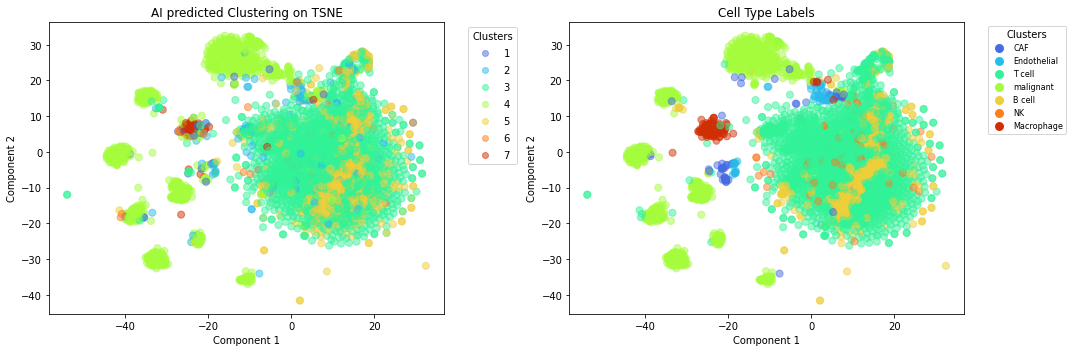

In [282]:
visualize_clustersCTs(tsne_result, predictions_list, df.iloc[:, 1], "AI predicted Clustering on TSNE")

We find that we can identify in 80% of the the cases the correct cell type. This is mostly to the highy accuracy in identifying cells as malignant cells. Visual evaluation of the data reveals that macrophages, endothelial and caf cells are poorly identified.

In [319]:
# Split data into training and test sets
y =  df.iloc[:, 0].values

# Train on 10% of the data to demonstrate predictive power
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.75, random_state=42)

# Check the size of the training and testing data set
print([np.size(y_train),np.size(y_test)])

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_series = pd.Series(y_train)
y_train_tensor = torch.tensor(y_train_series, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_series = pd.Series(y_test)
y_test_tensor = torch.tensor(y_test_series, dtype=torch.long)
# Combine X_test_tensor and y_test_tensor to create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader for the test data
test_loader = DataLoader(test_dataset, batch_size=32)

[1013, 3041]


In [320]:
# Define Neural network Parameters
input_dim = 150
hidden_dim = 150
output_dim = 20
num_hidden_layers = 4  # You can change this value to control the number of hidden layers

# Create an instance of the neural network
model = CustomNet(input_dim, hidden_dim, output_dim, num_hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [321]:
# Assuming you have already created X_train_tensor and y_train_tensor from X_train and y_train respectively.

# Training loop
num_epochs = 200
batch_size = 10

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        # Extract a batch of data
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss at each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/200, Loss: 2.2345
Epoch 2/200, Loss: 2.1943
Epoch 3/200, Loss: 2.1789
Epoch 4/200, Loss: 2.2839
Epoch 5/200, Loss: 2.2035
Epoch 6/200, Loss: 2.1503
Epoch 7/200, Loss: 2.1250
Epoch 8/200, Loss: 2.0873
Epoch 9/200, Loss: 2.0545
Epoch 10/200, Loss: 2.0194
Epoch 11/200, Loss: 1.9685
Epoch 12/200, Loss: 1.9071
Epoch 13/200, Loss: 1.8646
Epoch 14/200, Loss: 1.8126
Epoch 15/200, Loss: 1.7743
Epoch 16/200, Loss: 1.7456
Epoch 17/200, Loss: 1.6965
Epoch 18/200, Loss: 1.6585
Epoch 19/200, Loss: 1.6047
Epoch 20/200, Loss: 1.5648
Epoch 21/200, Loss: 1.5361
Epoch 22/200, Loss: 1.5139
Epoch 23/200, Loss: 1.4753
Epoch 24/200, Loss: 1.4474
Epoch 25/200, Loss: 1.4052
Epoch 26/200, Loss: 1.3653
Epoch 27/200, Loss: 1.3375
Epoch 28/200, Loss: 1.2966
Epoch 29/200, Loss: 1.2459
Epoch 30/200, Loss: 1.1816
Epoch 31/200, Loss: 1.1347
Epoch 32/200, Loss: 1.0608
Epoch 33/200, Loss: 1.0121
Epoch 34/200, Loss: 0.9587
Epoch 35/200, Loss: 0.9042
Epoch 36/200, Loss: 0.8601
Epoch 37/200, Loss: 0.8152
Epoch 38/2

In [322]:
# Evaluation on the test data
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
num_classes=output_dim

# Initialize dictionaries to keep track of correctly and incorrectly predicted counts for each class
correct_counts = {class_idx: 0 for class_idx in range(num_classes)}
incorrect_counts = {class_idx: 0 for class_idx in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count the number of correctly and incorrectly predicted data points for each class
        for class_idx in range(num_classes):
            correct_counts[class_idx] += ((predicted == labels) & (labels == class_idx)).sum().item()
            incorrect_counts[class_idx] += ((predicted != labels) & (labels == class_idx)).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Size of test: {total}")
print("Class-wise Accuracies:")
for class_idx in range(num_classes):
    if incorrect_counts[class_idx]>0 or correct_counts[class_idx]>0 :
        print(f"Cell Type {inverted_tumor_dict[class_idx]}:   ", f"Correct: {correct_counts[class_idx]}", f"False: {incorrect_counts[class_idx]}", f"Accuracy: {correct_counts[class_idx]/(correct_counts[class_idx]+incorrect_counts[class_idx])}",sep='\t')

Test Loss: 0.0000, Test Accuracy: 0.6189, Size of test: 3041
Class-wise Accuracies:
Cell Type MEL15:   	Correct: 2	False: 22	Accuracy: 0.08333333333333333
Cell Type MEL19:   	Correct: 110	False: 54	Accuracy: 0.6707317073170732
Cell Type MEL16:   	Correct: 8	False: 82	Accuracy: 0.08888888888888889
Cell Type MEL3:   	Correct: 32	False: 16	Accuracy: 0.6666666666666666
Cell Type MEL17:   	Correct: 101	False: 121	Accuracy: 0.45495495495495497
Cell Type MEL10:   	Correct: 180	False: 69	Accuracy: 0.7228915662650602
Cell Type MEL7:   	Correct: 27	False: 37	Accuracy: 0.421875
Cell Type MEL6:   	Correct: 46	False: 15	Accuracy: 0.7540983606557377
Cell Type MEL18:   	Correct: 154	False: 157	Accuracy: 0.49517684887459806
Cell Type MEL8:   	Correct: 75	False: 49	Accuracy: 0.6048387096774194
Cell Type MEL12:   	Correct: 544	False: 101	Accuracy: 0.8434108527131783
Cell Type MEL13:   	Correct: 261	False: 64	Accuracy: 0.803076923076923
Cell Type MEL14:   	Correct: 105	False: 35	Accuracy: 0.75
Cell Type 

In [323]:
# Initialize an empty list to store the predictions
predictions_list = []

# Pass each data point through the model and store the predictions in the list
with torch.no_grad():
    for inputs in X_imputed:
        # Convert the input data to a tensor and reshape if needed (adjust according to your model's input shape)
        inputs_tensor = torch.tensor(inputs, dtype=torch.float).unsqueeze(0)

        # Forward pass through the model to obtain the prediction
        outputs = model(inputs_tensor)

        # Get the predicted class (assuming your model is a classification model)
        _, predicted_class = torch.max(outputs, 1)

        # Append the predicted class (or the output of your regression model) to the predictions list
        predictions_list.append(predicted_class.item())

# Create a 1-dimensional DataFrame from the predictions list
predictions_df = pd.DataFrame(predictions_list, columns=['Predictions'])

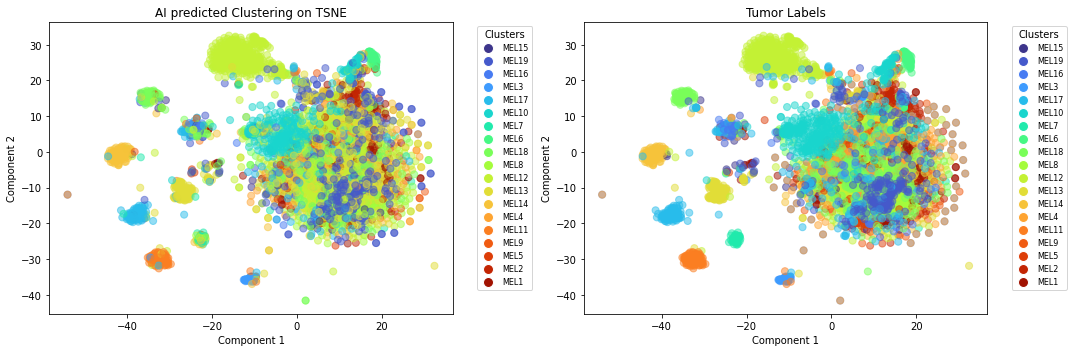

In [324]:
visualize_clustersTEs(tsne_result, predictions_list, df.iloc[:, 0], "AI predicted Clustering on TSNE")

Tumor environemtns are more poorly identified compared to cell types. Notably, the malignant tumor cells are well sperated in the restive tumor enviroments. Also for the non-malignant cells  some spatial structures can be identified.

## Evalutation on the most variable genes

In order to increase the quality of the result, we speculate the more variable genes carry more information about the cell types and tumor environment.

In [193]:
# Calculate the number of 0 entries in each column
zero_counts = (df_cut == 0).sum()

# Sort the columns based on the number of 0 entries in ascending order
sorted_columns = zero_counts.sort_values()

# Select the first 50 columns from the sorted DataFrame
filtered_df = df_cut[sorted_columns.index[:2000]].copy()
filtered_df.replace(0, np.nan, inplace=True)

# Convert X to a NumPy array since KNNImputer requires a NumPy array as input
X_array = filtered_df.values

k = 10  # Number of neighbors to consider (you can choose any value that suits your data)
imputer = KNNImputer(n_neighbors=k)

# Perform imputation
X_imputed = imputer.fit_transform(X_array)

# Convert X_imputed back to a DataFrame (if desired)
Imputed_df = pd.DataFrame(X_imputed, columns=filtered_df.columns)

In [204]:
# Calculate the variance or standard deviation for each gene
gene_variances = Imputed_df.var(axis=0)

# Sort the genes based on variance in descending order
sorted_genes = gene_variances.sort_values(ascending=False)

# Select the top 100 most variable genes from the sorted DataFrame
top_100_genes = Imputed_df[sorted_genes.index[:150]].copy()

print(top_50_genes)

0        TMSB4X       CD74      CXCR4     CTSB      CCL5     PTPRC    CORO1A  \
0      9.141700  11.462000  10.376000  1.71900   4.73420  2.329400  8.541800   
1     10.966000   8.935400   6.904000  1.72470  10.86000  1.798700  6.867900   
2      2.916924   3.444000   2.813607  4.17100   2.75420  0.845590  1.791452   
3      3.156820   2.420611   2.431516  6.50380   3.42920  0.521571  1.623242   
4      3.325920   2.364368   2.547839  7.74420   0.97233  0.998298  2.164765   
...         ...        ...        ...      ...       ...       ...       ...   
4049  10.308000   7.996200   8.537400  5.23830   7.57000  8.354900  6.991000   
4050   9.920400   6.763200   7.547150  2.02130   9.29010  7.954600  5.460700   
4051  10.071000   7.997900   6.711030  1.71230   8.61470  8.360800  7.430500   
4052  10.372000   8.603000   5.428700  1.67750   8.57130  8.110700  7.013600   
4053  10.682000   5.762000   6.218290  0.83473   8.56650  7.553700  7.764600   

0       LAPTM5   ARHGDIB     SRGN  ... 

In [289]:
# Split data into training and test sets
y =  df.iloc[:, 1].values

# Train on 10% of the data to demonstrate predictive power
X_train, X_test, y_train, y_test = train_test_split(top_100_genes.values, y, test_size=0.9, random_state=42)

# Check the size of the training and testing data set
print([np.size(y_train),np.size(y_test)])

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_series = pd.Series(y_train)
y_train_tensor = torch.tensor(y_train_series, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_series = pd.Series(y_test)
y_test_tensor = torch.tensor(y_test_series, dtype=torch.long)
# Combine X_test_tensor and y_test_tensor to create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader for the test data
test_loader = DataLoader(test_dataset, batch_size=32)

[405, 3649]


In [290]:
# Define Neural network Parameters
input_dim = 150
hidden_dim = 50
output_dim = 8
num_hidden_layers = 3  # You can change this value to control the number of hidden layers

# Create an instance of the neural network
model = CustomNet(input_dim, hidden_dim, output_dim, num_hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [291]:
# Training loop
num_epochs = 500
batch_size = 10

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        # Extract a batch of data
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss at each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/500, Loss: 1.9081
Epoch 2/500, Loss: 1.5820
Epoch 3/500, Loss: 1.4615
Epoch 4/500, Loss: 1.3239
Epoch 5/500, Loss: 1.1443
Epoch 6/500, Loss: 0.9419
Epoch 7/500, Loss: 0.8220
Epoch 8/500, Loss: 0.7461
Epoch 9/500, Loss: 0.6877
Epoch 10/500, Loss: 0.6395
Epoch 11/500, Loss: 0.5980
Epoch 12/500, Loss: 0.5598
Epoch 13/500, Loss: 0.5262
Epoch 14/500, Loss: 0.4962
Epoch 15/500, Loss: 0.4711
Epoch 16/500, Loss: 0.4475
Epoch 17/500, Loss: 0.4259
Epoch 18/500, Loss: 0.4056
Epoch 19/500, Loss: 0.3864
Epoch 20/500, Loss: 0.3724
Epoch 21/500, Loss: 0.3607
Epoch 22/500, Loss: 0.3500
Epoch 23/500, Loss: 0.3414
Epoch 24/500, Loss: 0.3366
Epoch 25/500, Loss: 0.3338
Epoch 26/500, Loss: 0.3277
Epoch 27/500, Loss: 0.3250
Epoch 28/500, Loss: 0.3198
Epoch 29/500, Loss: 0.3156
Epoch 30/500, Loss: 0.3084
Epoch 31/500, Loss: 0.3037
Epoch 32/500, Loss: 0.2980
Epoch 33/500, Loss: 0.2905
Epoch 34/500, Loss: 0.2849
Epoch 35/500, Loss: 0.2760
Epoch 36/500, Loss: 0.2676
Epoch 37/500, Loss: 0.2601
Epoch 38/5

Epoch 303/500, Loss: 0.0001
Epoch 304/500, Loss: 0.0001
Epoch 305/500, Loss: 0.0001
Epoch 306/500, Loss: 0.0001
Epoch 307/500, Loss: 0.0001
Epoch 308/500, Loss: 0.0001
Epoch 309/500, Loss: 0.0001
Epoch 310/500, Loss: 0.0001
Epoch 311/500, Loss: 0.0001
Epoch 312/500, Loss: 0.0001
Epoch 313/500, Loss: 0.0001
Epoch 314/500, Loss: 0.0001
Epoch 315/500, Loss: 0.0001
Epoch 316/500, Loss: 0.0001
Epoch 317/500, Loss: 0.0001
Epoch 318/500, Loss: 0.0001
Epoch 319/500, Loss: 0.0001
Epoch 320/500, Loss: 0.0001
Epoch 321/500, Loss: 0.0001
Epoch 322/500, Loss: 0.0001
Epoch 323/500, Loss: 0.0001
Epoch 324/500, Loss: 0.0001
Epoch 325/500, Loss: 0.0001
Epoch 326/500, Loss: 0.0001
Epoch 327/500, Loss: 0.0001
Epoch 328/500, Loss: 0.0001
Epoch 329/500, Loss: 0.0001
Epoch 330/500, Loss: 0.0001
Epoch 331/500, Loss: 0.0001
Epoch 332/500, Loss: 0.0001
Epoch 333/500, Loss: 0.0001
Epoch 334/500, Loss: 0.0001
Epoch 335/500, Loss: 0.0001
Epoch 336/500, Loss: 0.0001
Epoch 337/500, Loss: 0.0001
Epoch 338/500, Loss:

In [292]:
# Evaluation on the test data
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
num_classes=output_dim

# Initialize dictionaries to keep track of correctly and incorrectly predicted counts for each class
correct_counts = {class_idx: 0 for class_idx in range(num_classes)}
incorrect_counts = {class_idx: 0 for class_idx in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count the number of correctly and incorrectly predicted data points for each class
        for class_idx in range(num_classes):
            correct_counts[class_idx] += ((predicted == labels) & (labels == class_idx)).sum().item()
            incorrect_counts[class_idx] += ((predicted != labels) & (labels == class_idx)).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Size of test: {total}")
print("Class-wise Accuracies:")
for class_idx in range(num_classes):
    if incorrect_counts[class_idx]>0 or correct_counts[class_idx]>0 :
        print(f"Cell Type {inverted_cell_type_dict[class_idx]}:", f"Correct: {correct_counts[class_idx]}", f"False: {incorrect_counts[class_idx]}", f"Accuracy: {correct_counts[class_idx]/(correct_counts[class_idx]+incorrect_counts[class_idx])}",sep='\t')
        
        

Test Loss: 0.0000, Test Accuracy: 0.9230, Size of test: 3649
Class-wise Accuracies:
Cell Type CAF:	Correct: 27	False: 31	Accuracy: 0.46551724137931033
Cell Type Endothelial:	Correct: 39	False: 16	Accuracy: 0.7090909090909091
Cell Type T cell:	Correct: 1774	False: 74	Accuracy: 0.95995670995671
Cell Type malignant:	Correct: 1038	False: 20	Accuracy: 0.9810964083175804
Cell Type B cell:	Correct: 393	False: 74	Accuracy: 0.841541755888651
Cell Type NK:	Correct: 0	False: 48	Accuracy: 0.0
Cell Type Macrophage:	Correct: 97	False: 18	Accuracy: 0.8434782608695652


In [293]:
# Initialize an empty list to store the predictions
predictions_list = []

# Pass each data point through the model and store the predictions in the list
with torch.no_grad():
    for inputs in top_100_genes.values:
        # Convert the input data to a tensor and reshape if needed (adjust according to your model's input shape)
        inputs_tensor = torch.tensor(inputs, dtype=torch.float).unsqueeze(0)

        # Forward pass through the model to obtain the prediction
        outputs = model(inputs_tensor)

        # Get the predicted class (assuming your model is a classification model)
        _, predicted_class = torch.max(outputs, 1)

        # Append the predicted class (or the output of your regression model) to the predictions list
        predictions_list.append(predicted_class.item())

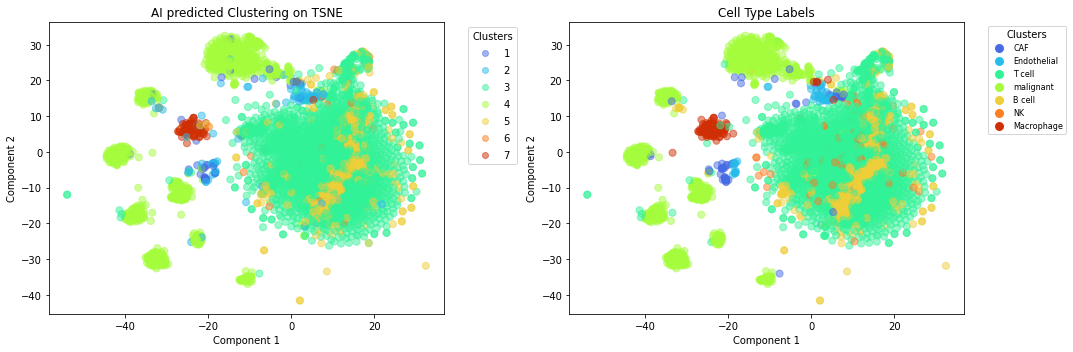

In [294]:
visualize_clustersCTs(tsne_result, predictions_list, df.iloc[:, 1], "AI predicted Clustering on TSNE")

With 92% accuracy the quality of the identification of cell types could be increased. In particular now macrophages, entothelial, and caf cells are more accurately identified, as valided also by a visual evalutation. NK cells are hardly detected. This could potentially be improved by a specific training on NK cell by desinging a more accurated training data set. 

In [345]:
# Split data into training and test sets
y =  df.iloc[:, 0].values

# Train on 10% of the data to demonstrate predictive power
X_train, X_test, y_train, y_test = train_test_split(top_100_genes.values, y, test_size=0.75, random_state=42)

# Check the size of the training and testing data set
print([np.size(y_train),np.size(y_test)])

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_series = pd.Series(y_train)
y_train_tensor = torch.tensor(y_train_series, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_series = pd.Series(y_test)
y_test_tensor = torch.tensor(y_test_series, dtype=torch.long)
# Combine X_test_tensor and y_test_tensor to create a TensorDataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a DataLoader for the test data
test_loader = DataLoader(test_dataset, batch_size=32)

[1013, 3041]


In [357]:
# Define Neural network Parameters
input_dim = 150
hidden_dim = 200
output_dim = 20
num_hidden_layers = 4  # You can change this value to control the number of hidden layers

# Create an instance of the neural network
model = CustomNet(input_dim, hidden_dim, output_dim, num_hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [358]:
# Training loop
num_epochs = 150
batch_size = 10

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        # Extract a batch of data
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss at each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 1/150, Loss: 2.0597
Epoch 2/150, Loss: 1.7148
Epoch 3/150, Loss: 1.5871
Epoch 4/150, Loss: 1.3784
Epoch 5/150, Loss: 1.2109
Epoch 6/150, Loss: 1.1206
Epoch 7/150, Loss: 1.0486
Epoch 8/150, Loss: 0.9662
Epoch 9/150, Loss: 0.8611
Epoch 10/150, Loss: 0.7639
Epoch 11/150, Loss: 0.6564
Epoch 12/150, Loss: 0.5470
Epoch 13/150, Loss: 0.4564
Epoch 14/150, Loss: 0.3694
Epoch 15/150, Loss: 0.3099
Epoch 16/150, Loss: 0.2656
Epoch 17/150, Loss: 0.2281
Epoch 18/150, Loss: 0.1996
Epoch 19/150, Loss: 0.1636
Epoch 20/150, Loss: 0.1383
Epoch 21/150, Loss: 0.1226
Epoch 22/150, Loss: 0.1002
Epoch 23/150, Loss: 0.0860
Epoch 24/150, Loss: 0.0722
Epoch 25/150, Loss: 0.0648
Epoch 26/150, Loss: 0.0543
Epoch 27/150, Loss: 0.0447
Epoch 28/150, Loss: 0.0370
Epoch 29/150, Loss: 0.0298
Epoch 30/150, Loss: 0.0257
Epoch 31/150, Loss: 0.0236
Epoch 32/150, Loss: 0.0200
Epoch 33/150, Loss: 0.0198
Epoch 34/150, Loss: 0.0177
Epoch 35/150, Loss: 0.0174
Epoch 36/150, Loss: 0.0168
Epoch 37/150, Loss: 0.0175
Epoch 38/1

In [359]:
# Evaluation on the test data
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
num_classes=output_dim

# Initialize dictionaries to keep track of correctly and incorrectly predicted counts for each class
correct_counts = {class_idx: 0 for class_idx in range(num_classes)}
incorrect_counts = {class_idx: 0 for class_idx in range(num_classes)}

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Count the number of correctly and incorrectly predicted data points for each class
        for class_idx in range(num_classes):
            correct_counts[class_idx] += ((predicted == labels) & (labels == class_idx)).sum().item()
            incorrect_counts[class_idx] += ((predicted != labels) & (labels == class_idx)).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Size of test: {total}")
print("Class-wise Accuracies:")
for class_idx in range(num_classes):
    if incorrect_counts[class_idx]>0 or correct_counts[class_idx]>0 :
        print(f"Cell Type {inverted_tumor_dict[class_idx]}:   ", f"Correct: {correct_counts[class_idx]}", f"False: {incorrect_counts[class_idx]}", f"Accuracy: {correct_counts[class_idx]/(correct_counts[class_idx]+incorrect_counts[class_idx])}",sep='\t')
        
        

Test Loss: 0.0000, Test Accuracy: 0.6018, Size of test: 3041
Class-wise Accuracies:
Cell Type MEL15:   	Correct: 2	False: 22	Accuracy: 0.08333333333333333
Cell Type MEL19:   	Correct: 82	False: 82	Accuracy: 0.5
Cell Type MEL16:   	Correct: 11	False: 79	Accuracy: 0.12222222222222222
Cell Type MEL3:   	Correct: 41	False: 7	Accuracy: 0.8541666666666666
Cell Type MEL17:   	Correct: 120	False: 102	Accuracy: 0.5405405405405406
Cell Type MEL10:   	Correct: 196	False: 53	Accuracy: 0.7871485943775101
Cell Type MEL7:   	Correct: 33	False: 31	Accuracy: 0.515625
Cell Type MEL6:   	Correct: 48	False: 13	Accuracy: 0.7868852459016393
Cell Type MEL18:   	Correct: 170	False: 141	Accuracy: 0.5466237942122186
Cell Type MEL8:   	Correct: 55	False: 69	Accuracy: 0.4435483870967742
Cell Type MEL12:   	Correct: 527	False: 118	Accuracy: 0.8170542635658915
Cell Type MEL13:   	Correct: 213	False: 112	Accuracy: 0.6553846153846153
Cell Type MEL14:   	Correct: 104	False: 36	Accuracy: 0.7428571428571429
Cell Type ME

In [360]:
# Initialize an empty list to store the predictions
predictions_list = []

# Pass each data point through the model and store the predictions in the list
with torch.no_grad():
    for inputs in top_100_genes.values:
        # Convert the input data to a tensor and reshape if needed (adjust according to your model's input shape)
        inputs_tensor = torch.tensor(inputs, dtype=torch.float).unsqueeze(0)

        # Forward pass through the model to obtain the prediction
        outputs = model(inputs_tensor)

        # Get the predicted class (assuming your model is a classification model)
        _, predicted_class = torch.max(outputs, 1)

        # Append the predicted class (or the output of your regression model) to the predictions list
        predictions_list.append(predicted_class.item())

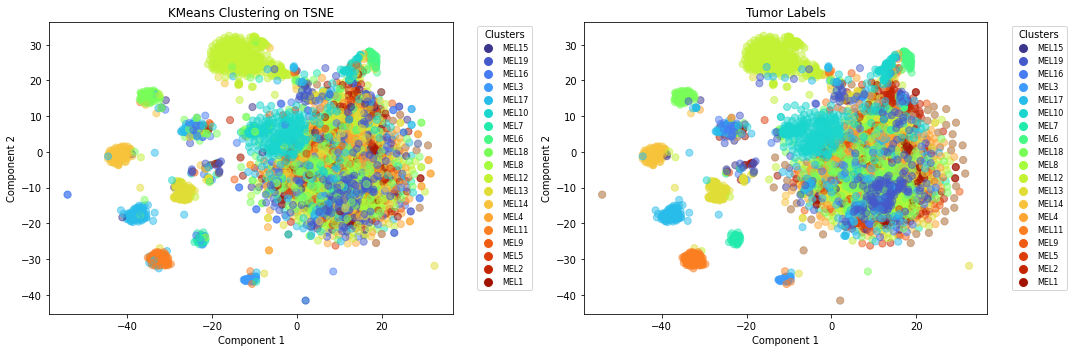

In [361]:
visualize_clustersTEs(tsne_result, predictions_list, df.iloc[:, 0], "KMeans Clustering on TSNE")

In contrast to the cell type the identification of tumor environemts was not increased but ineed performes slighlty less accurate. This indicates that more information in terms of genes need to be considered for the analysis.